# Uniaxial pull of a rectangle

Plane Elastic problem


Uni-axial pull in the direction $\mathbf{e}_1$ of a rectangle of dimension $L_1 \times L_2$.

We use the hyper-singular kernel.

In [1]:
# %% importing BigWham 
import sys
import os
import numpy as np

from bigwham4py import BEMatrix


In [4]:
#%% Elastic properties
G = 1.0
nu = 0.25
E = (2 * G) * (1 + nu)

# %% Mesh 
L1 = 1
L2 = 1
n1 = 10*1
n2= 10*1
nelts = n1*2 +n2*2

# counter clock-wise for inner problem 
coor1Dx = np.linspace(0, L1, n1+ 1)
coor1Dy = np.linspace(0, L2, n2+ 1)

coor =np.append(np.array([coor1Dy[0:]*0.0, coor1Dy[:] ]),np.array([coor1Dx[1:], coor1Dx[1:] * 0.0+L2]) ,axis=1)

coor = np.append(coor,np.array([np.flip(coor1Dy)[1:-1]*0.+L1,np.flip(coor1Dy)[1:-1]]),axis=1)
coor = np.append(coor,(np.array([np.flip(coor1Dx[1:]), np.flip(coor1Dx[1:]) * 0.0])),axis=1)

coor = np.transpose(coor)

conn = np.fromfunction(lambda i, j: i + j, (nelts-1, 2), dtype=np.int_)
conn = np.append(conn,np.array([[nelts-1,0]]),axis=0)


In [5]:
kernel = "2DP0-H"
elas_prop = np.array([E, nu])
eta=3.0
max_leaf_size = 64
eps_aca = 1.0e-4
h = BEMatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca)

colpts=h.getCollocationPoints()

my_colPts = np.asarray([ np.mean(coor[conn[e]],axis=0) for e in range(nelts)  ])
np.sum(my_colPts==colpts)==nelts*2

 Now setting things for kernel ... 2DP0-H with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  1e-06
 binary cluster tree depth =0
 Number of blocks =1
 Number of full blocks =1
 Number of low rank blocks =0
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 1 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.003259
Compression ratio - 1
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 1, eps_aca = 0.0001, eta = 3
Hierarchical matrix  construction time = :  0.003281
--------------------


True

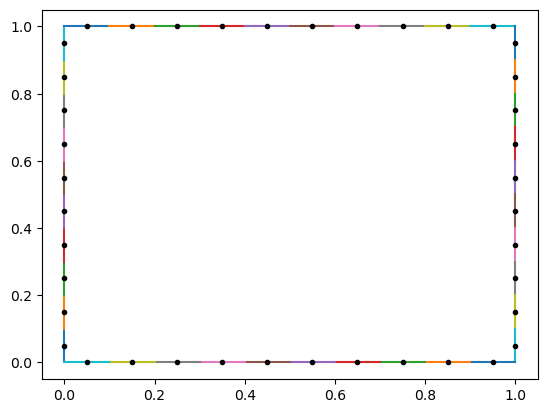

In [6]:
# plot mesh + collocation points location
import matplotlib.pyplot as plt

for e in range(nelts):
    plt.plot(coor[conn[e],0],coor[conn[e],1])

plt.plot(colpts[:,0],colpts[:,1],'.k')
#plt.plot(my_colPts[:,0],my_colPts[:,1],'.r')


In [7]:
h.getCompression()#
#h.plotPattern()

1.0

In [8]:
# boundary conditions
#  
# traction on left + right sides, free on top & bottom sides
left_pts=np.where(colpts[:,0]==0.)[0]
right_pts=np.where(colpts[:,0]==L1)[0]
bot_pts = np.where(colpts[:,1]==0.)[0]
top_pts = np.where(colpts[:,1]==L2)[0]

In [9]:
tractions_g = np.zeros(2*nelts)
tractions_g[right_pts*2]=1.0  # pull along x1 (-> corresponds to local normal dof for right side)
tractions_g[left_pts*2]=-1.0  # pull along x1 (-> corresponds to localnormal dof for left side)

tractions=h.convert_to_local(tractions_g)
from scipy.sparse.linalg import gmres
jac_prec = h.H_jacobi_prec()
jac_ilu = h.H_ILU_prec()
d = gmres(h, tractions,M=jac_ilu,maxiter=500,tol=1e-6,restart=500)[0] #
dd_global = -h.convert_to_global(d).reshape((-1, 2))

# plot displacement w.r. to the mean (to get rif of rigit body motion)
m1=np.mean(dd_global[:,0])
m2=np.mean(dd_global[:,1])

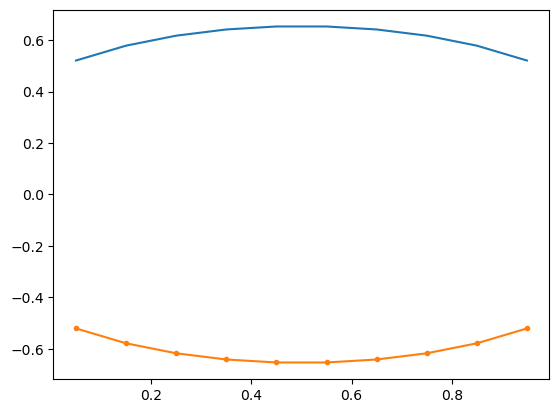

In [10]:
# plot of u_1 for left and right sides  along y ...
plt.plot(colpts[left_pts,1],dd_global[left_pts,0]-m1)
plt.plot(colpts[right_pts,1],dd_global[right_pts,0]-m1,'.-')

In [11]:
# be careful must take 1/2 of dd for the real displacement ! 
L1/E 
np.mean(dd_global[left_pts,0]-m1)
rel_error=np.abs(L1/E-np.median(dd_global[left_pts,0]-m1))/(L1/E)
print("Analytical u_x (left)",(L1/E))
print("num u_x (left)",np.median(dd_global[left_pts,0]-m1))

print('relative error ',rel_error)

Analytical u_x (left) 0.4
num u_x (left) 0.6171255273416322
relative error  0.5428138183540804


0.05

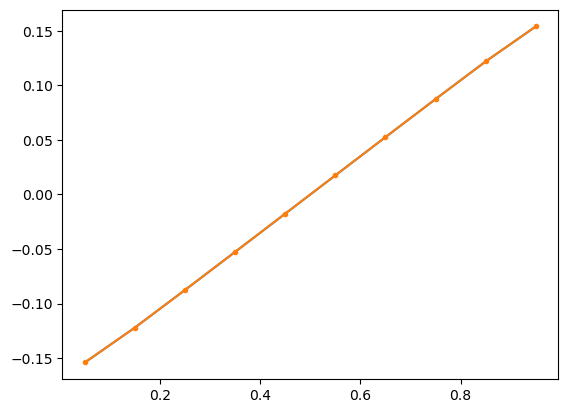

In [12]:
# plot of u_2 along y for left and right sides (poisson's effect)
plt.plot(colpts[left_pts,1],dd_global[left_pts,1]-m2)
plt.plot(colpts[right_pts,1],dd_global[right_pts,1]-m2,'.-')
# max u_y at top of both sides :
L1/E/2 * nu

In [13]:
1-np.max(dd_global[left_pts,1]-m2)/(L1/E/2 * nu)

-2.0777240817312745

true u_y (top)  0.05
num median 0.11783955832934467
num median 0.11854837201101892
rel error median 1.3567911665868932


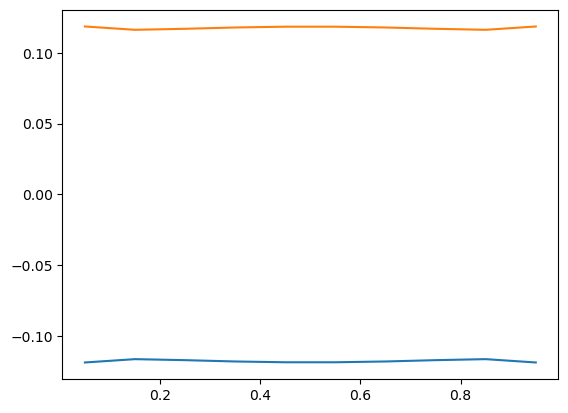

In [14]:
# plot of u_2 along e1 for top and bottom sides 
plt.plot(colpts[bot_pts,0],dd_global[bot_pts,1]-m2)
plt.plot(colpts[top_pts,0],dd_global[top_pts,1]-m2)

print('true u_y (top) ',(L1/E/2 * nu))
print('num median',np.median(dd_global[top_pts,1]-m2))
print('num median',np.max(dd_global[top_pts,1]-m2))

print('rel error median',np.abs(np.median(dd_global[top_pts,1]-m2)-(L1/E/2 * nu))/((L1/E/2 * nu)) )#  median relative error 


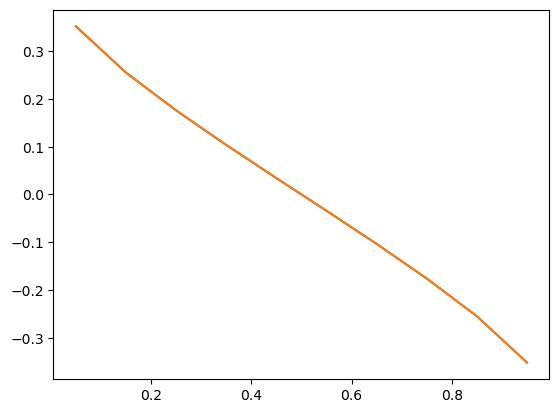

In [15]:
# plot of u_1 along e1 for top and bottom sides 
plt.plot(colpts[bot_pts,0],dd_global[bot_pts,0]-m1)
plt.plot(colpts[top_pts,0],dd_global[top_pts,0]-m1)

In [16]:
#bot_pts
#dd_global[bot_pts,0]-m1

In [15]:
(coor.shape[0]==2 or coor.shape[0] ==160 )

False

In [16]:
coor.shape[0] ==160

False